# Load and check data

In [1]:
import time
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import nltk

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics, model_selection, preprocessing
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline

import xgboost as xgb

/home/guido/.conda/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


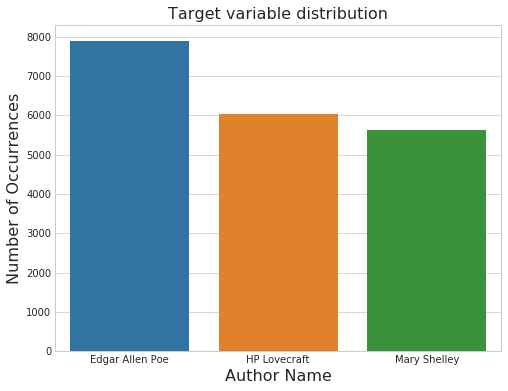

In [4]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(8, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(x=train.author.map(z).unique(), y=train.author.value_counts().values)

# Wordclouds

## Visualise each author's work

In [5]:
from imageio import imread
from wordcloud import WordCloud, STOPWORDS

(-0.5, 399.5, 199.5, -0.5)

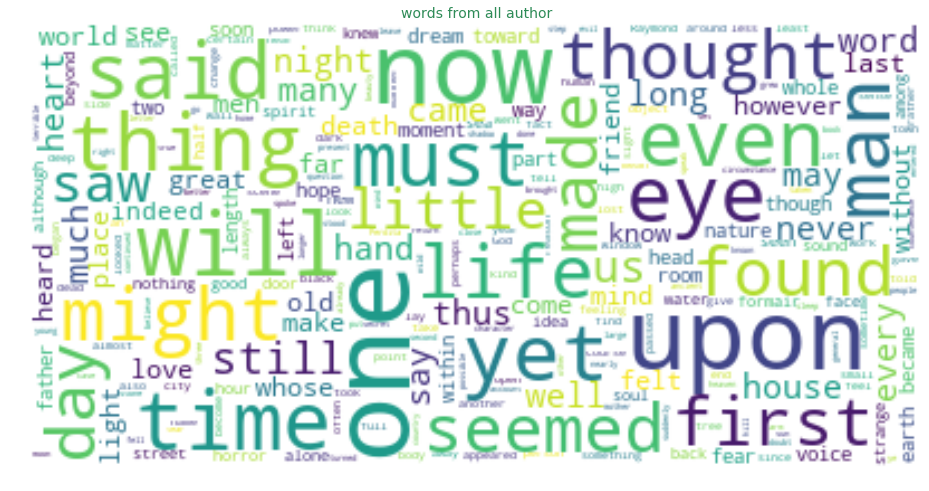

In [6]:
wc = WordCloud(
    background_color="white",
    max_words=5000,
    stopwords=STOPWORDS,
    max_font_size=50)
# generate word cloud
wc.generate(" ".join(train.text.values))

# show
plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14, color='seagreen')
plt.axis("off")

In [7]:
img1 = imread("../images/eap.png")
img2 = imread("../images/mws.png")
img3 = imread("../images/hpl.png")

In [8]:
eap = train[train.author == "EAP"]["text"].values
mws = train[train.author == "MWS"]["text"].values
hpl = train[train.author == "HPL"]["text"].values

(-0.5, 639.5, 390.5, -0.5)

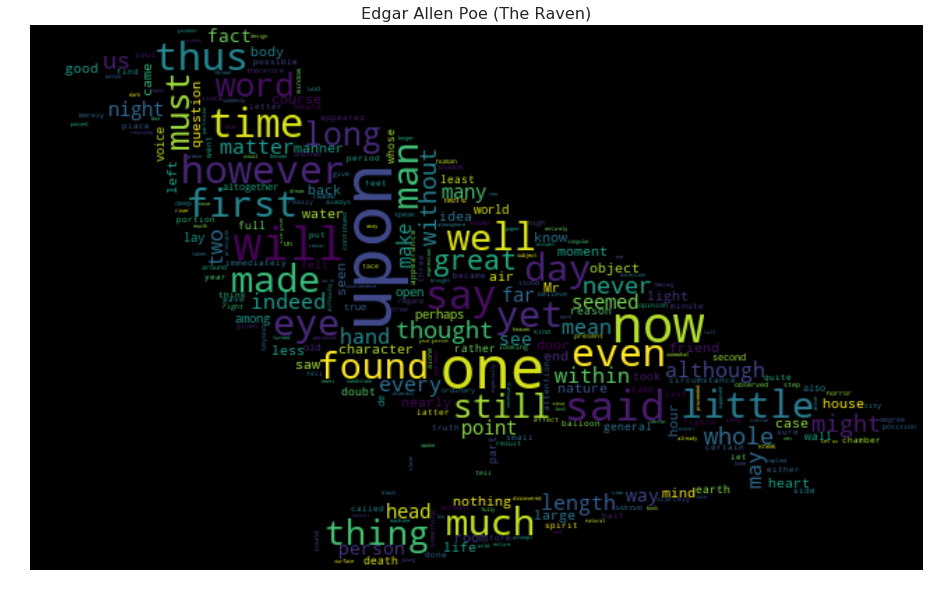

In [9]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img1,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(eap))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Edgar Allen Poe (The Raven)", fontsize=16)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

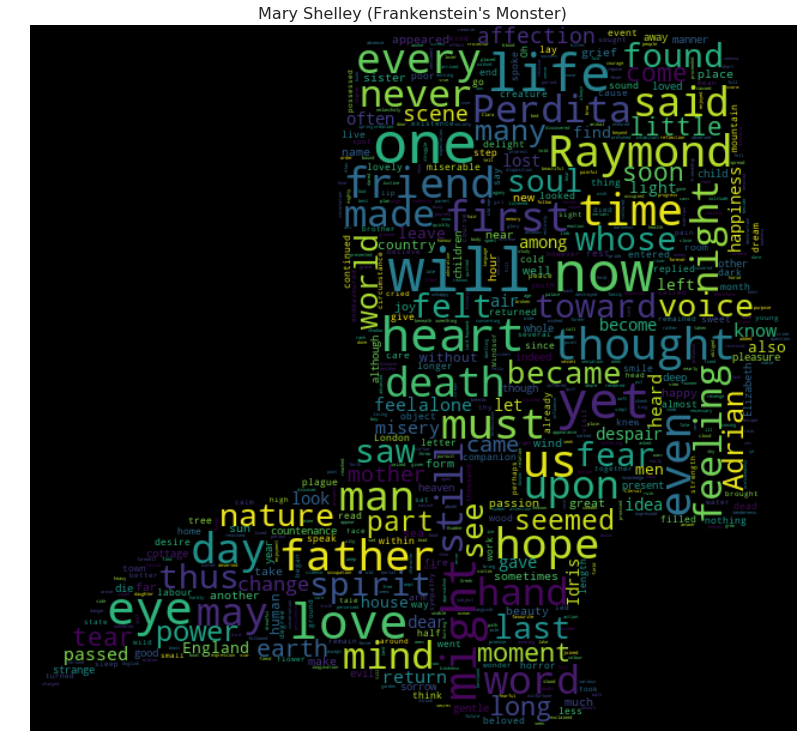

In [10]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img2,
    stopwords=STOPWORDS,
    max_font_size=50)
wc.generate(" ".join(mws))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize=16)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

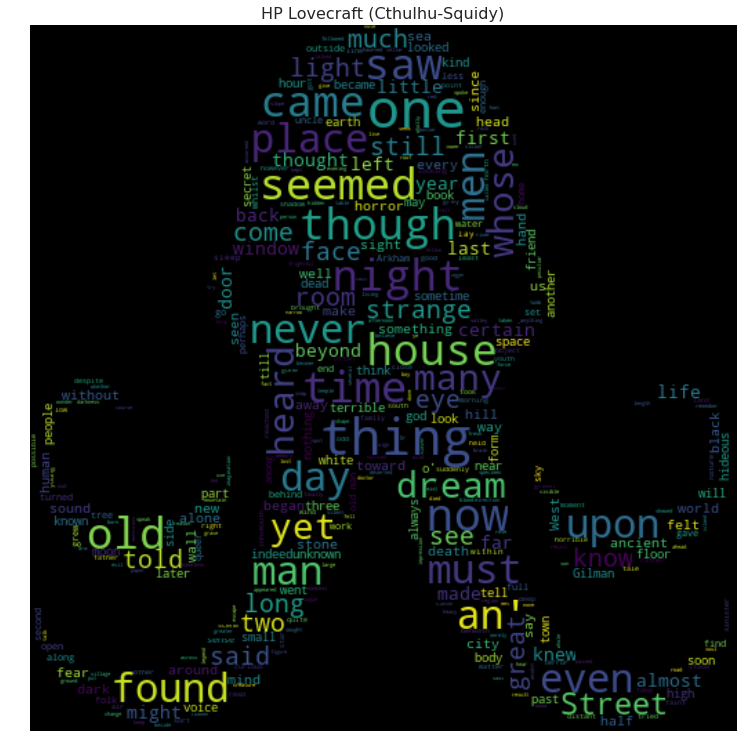

In [11]:
wc = WordCloud(
    background_color="black",
    max_words=10000,
    mask=img3,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(" ".join(hpl))

plt.figure(figsize=(16, 13))
plt.imshow(wc, interpolation='bilinear')
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=16)
plt.axis('off')

# Natural Language Processing

## Tokenization

In [12]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [13]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [15]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [16]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [17]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("ascertaining")))

The lemmatized form of leaves is: leaf
The lemmatized form of leaves is: ascertaining


## Vectorizing Raw Text

In [18]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [19]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## Text based features

In [3]:
import string


def word_count(raw):
    return len(raw['text'].split())


def char_count(raw):
    return len(raw['text'])


def word_len_mean(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return np.mean([len(w) for w in text_list])


def unique_word_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len(list(set(text_list)))


def stopwords_count(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    return len([w for w in text_list if w in stopwords])


def punctuations_count(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    return len([w for w in text_list if w in string.punctuation])


def word_upper_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.isupper()])


def word_title_count(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    return len([w for w in text_list if w.istitle()])


def unique_word_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    unique_word_count = len(list(set(text_list)))
    word_count = len(text_list)
    return unique_word_count / word_count


def stopwords_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    stopwords = nltk.corpus.stopwords.words('english')

    stopwords_count = len([w for w in text_list if w in stopwords])
    word_count = len(text_list)
    return stopwords_count / word_count


def punctuations_fraction(raw):
    text = raw['text'].lower()
    text_list = nltk.word_tokenize(text)

    punctuation_count = len([w for w in text_list if w in string.punctuation])
    char_count = len(text)
    return punctuation_count / char_count


def word_upper_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_upper_count = len([w for w in text_list if w.isupper()])
    word_count = len(text_list)
    return word_upper_count / word_count


def word_title_fraction(raw):
    text = raw['text']
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    word_title_count = len([w for w in text_list if w.istitle()])
    word_count = len(text_list)
    return word_title_count / word_count


def noun_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    noun_count = len(
        [w for w in pos_list if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')])
    word_count = len(text_list)
    return noun_count / word_count


def adj_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    adj_count = len([w for w in pos_list if w[1] in ('JJ', 'JJR', 'JJS')])
    word_count = len(text_list)
    return adj_count / word_count


def verbs_fraction(raw):
    text = raw['text'].lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    text_list = tokenizer.tokenize(text)

    pos_list = nltk.pos_tag(text_list)
    verbs_count = len([
        w for w in pos_list
        if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
    ])
    word_count = len(text_list)
    return verbs_count / word_count

In [4]:
for dataset in full_data:
    start = time.time()
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)
    dataset['char_count'] = dataset.apply(lambda raw: char_count(raw), axis=1)
    dataset['word_len_mean'] = dataset.apply(lambda raw: word_len_mean(raw), axis=1)
    end = time.time()
    print("Time is {}.".format(end - start))
    
    start = time.time()
    dataset['unique_word_count'] = dataset.apply(lambda raw: unique_word_count(raw), axis=1)
    dataset['stopwords_count'] = dataset.apply(lambda raw: stopwords_count(raw), axis=1)
    dataset['punctuations_count'] = dataset.apply(lambda raw: punctuations_count(raw), axis=1)
    dataset['word_upper_count'] = dataset.apply(lambda raw: word_upper_count(raw), axis=1)
    dataset['word_title_count'] = dataset.apply(lambda raw: word_title_count(raw), axis=1)
    end = time.time()
    print("Time is {}.".format(end - start))
    
    start = time.time()
    dataset['unique_word_fraction'] = dataset.apply(lambda raw: unique_word_fraction(raw), axis=1)
    dataset['stopwords_fraction'] = dataset.apply(lambda raw: stopwords_fraction(raw), axis=1)
    dataset['punctuations_fraction'] = dataset.apply(lambda raw: punctuations_fraction(raw), axis=1)
    dataset['word_upper_fraction'] = dataset.apply(lambda raw: word_upper_fraction(raw), axis=1)
    dataset['word_title_fraction'] = dataset.apply(lambda raw: word_title_fraction(raw), axis=1)
    end = time.time()
    print("Time is {}.".format(end - start))
    
    start = time.time()
    #dataset['noun_fraction'] = dataset.apply(lambda raw: noun_fraction(raw), axis=1)
    #dataset['adj_fraction'] = dataset.apply(lambda raw: adj_fraction(raw), axis=1)
    #dataset['verbs_fraction'] = dataset.apply(lambda raw: verbs_fraction(raw), axis=1)
    end = time.time()
    print("Time is {}.".format(end - start))

Time is 3.0819389820098877.
Time is 19.475534915924072.
Time is 18.449994802474976.
Time is 4.76837158203125e-07.
Time is 1.3596861362457275.
Time is 7.526210308074951.
Time is 7.721622943878174.
Time is 2.384185791015625e-07.


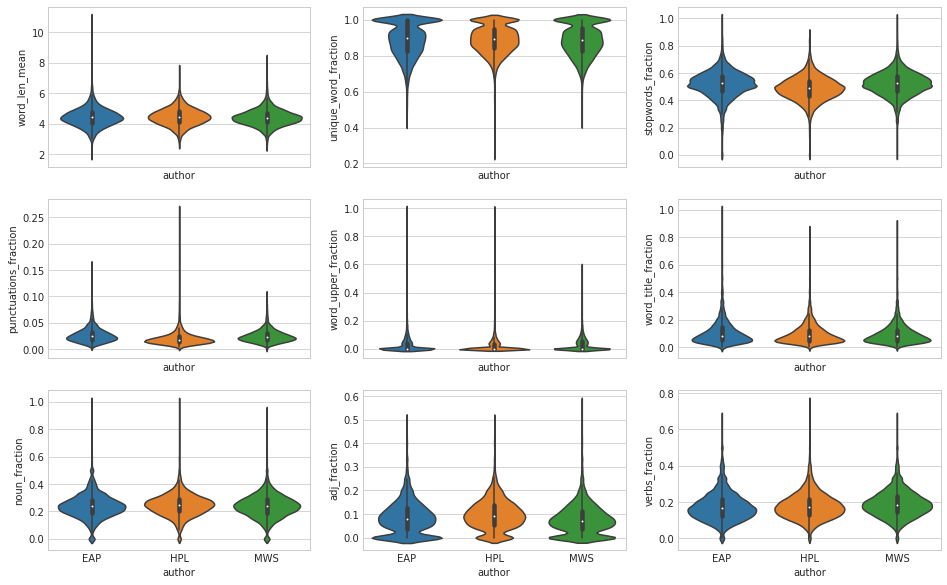

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(16, 10))
sns.violinplot(x='author', y='word_len_mean', data=train, ax=ax[0, 0])
sns.violinplot(x='author', y='unique_word_fraction', data=train, ax=ax[0, 1])
sns.violinplot(x='author', y='stopwords_fraction', data=train, ax=ax[0, 2])

sns.violinplot(x='author', y='punctuations_fraction', data=train, ax=ax[1, 0])
sns.violinplot(x='author', y='word_upper_fraction', data=train, ax=ax[1, 1])
sns.violinplot(x='author', y='word_title_fraction', data=train, ax=ax[1, 2])

sns.violinplot(x='author', y='noun_fraction', data=train, ax=ax[2, 0])
sns.violinplot(x='author', y='adj_fraction', data=train, ax=ax[2, 1])
sns.violinplot(x='author', y='verbs_fraction', data=train, ax=ax[2, 2])

## word Count and TFIDF features

In [5]:
lemm = nltk.stem.WordNetLemmatizer()


class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmTfidfVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [6]:
# word vectorizer
start = time.time()
ctv = LemmCountVectorizer(
    stop_words='english', token_pattern=r'\w{1,}', ngram_range=(1, 3))
ctv.fit(list(train.text.values) + list(test.text.values))
ctw_train = ctv.transform(train.text.values)
ctw_test = ctv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
tfv = LemmTfidfVectorizer(
    min_df=3,
    strip_accents='unicode',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 3),
    sublinear_tf=1,
    stop_words='english')
tfv.fit(list(train.text.values) + list(test.text.values))
tfw_train = tfv.transform(train.text.values)
tfw_test = tfv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

Time is 24.53563690185547.
Time is 19.02119016647339.


## char Count and TFIDF features

In [7]:
# char vectorizer
start = time.time()
ctcv = CountVectorizer(
    ngram_range=(1, 7), analyzer='char', stop_words='english')
ctcv.fit(list(train.text.values) + list(test.text.values))
ctc_train = ctcv.transform(train.text.values)
ctc_test = ctcv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
tfcv = TfidfVectorizer(
    ngram_range=(1, 7), analyzer='char', stop_words='english')
tfcv.fit(list(train.text.values) + list(test.text.values))
tfc_train = tfcv.transform(train.text.values)
tfc_test = tfcv.transform(test.text.values)
end = time.time()
print("Time is {}.".format(end - start))

Time is 62.00063467025757.
Time is 71.6954550743103.


## SVD and Scale on word TFIDF features

In [8]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
start = time.time()
n_comp = 120
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svdw_train = svd.fit_transform(tfw_train)
svdw_test = svd.transform(tfw_test)
end = time.time()
print("Time is {}.".format(end - start))

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
start = time.time()
scl = StandardScaler()
scl_svdw_train = scl.fit_transform(svdw_train)
scl_svdw_test = scl.transform(svdw_test)

scl_svdw_train_df = pd.DataFrame(scl_svdw_train)
scl_svdw_test_df = pd.DataFrame(scl_svdw_test)
scl_svdw_train_df.columns = ['scl_svdw_' + str(i) for i in range(n_comp)]
scl_svdw_test_df.columns = ['scl_svdw_' + str(i) for i in range(n_comp)]
train = pd.concat([train, scl_svdw_train_df], axis=1)
test = pd.concat([test, scl_svdw_test_df], axis=1)

end = time.time()
print("Time is {}.".format(end - start))

Time is 7.693424224853516.
Time is 0.06330561637878418.


## SVD and Scale on char TFIDF features

In [9]:
start = time.time()
n_comp = 120
svd = TruncatedSVD(n_components=n_comp, algorithm='arpack', random_state=2017)

svdc_train = svd.fit_transform(tfc_train)
svdc_test = svd.transform(tfc_test)
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
scl = StandardScaler()
scl_svdc_train = scl.fit_transform(svdc_train)
scl_svdc_test = scl.transform(svdc_test)

scl_svdc_train_df = pd.DataFrame(scl_svdc_train)
scl_svdc_test_df = pd.DataFrame(scl_svdc_test)
scl_svdc_train_df.columns = ['scl_svdc_' + str(i) for i in range(n_comp)]
scl_svdc_test_df.columns = ['scl_svdc_' + str(i) for i in range(n_comp)]
train = pd.concat([train, scl_svdc_train_df], axis=1)
test = pd.concat([test, scl_svdc_test_df], axis=1)

end = time.time()
print("Time is {}.".format(end - start))

Time is 91.04611110687256.
Time is 0.08884906768798828.


In [28]:
# Try to adjust the parameters of the TruncatedSVD n_components
#n_splits = 5
#kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
#cv_scores = []
#pred_full_test = 0
#pred_train = np.zeros([train.shape[0], 3])
#
#for idx_dev, idx_val in kf.split(svd_train):
#    x_dev, x_val = svd_train[idx_dev], svd_train[idx_val]
#    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
#    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, svd_test)
#    pred_full_test = pred_full_test + pred_y_test
#    pred_train[idx_val, :] = pred_y_val
#    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
#    break
#pred_full_test = pred_full_test / float(n_splits)
#print("Mean cv score : {}".format(np.mean(cv_scores)))

## Markov event based features

In [10]:
class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0

    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens - 1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if (index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [11]:
# markov chain based features, order words memory
def make_higher_order_markov_model(data, order):
    markov_model = dict()

    for char_list in data:
        for i in range(len(char_list) - order):
            # Create the window
            window = tuple(char_list[i:i + order])
            # Add to the dictionary
            if window in markov_model:
                # We have to just append to the existing Dictogram
                markov_model[window].update([char_list[i + order]])
            else:
                markov_model[window] = Dictogram([char_list[i + order]])
    return markov_model


def make_tuples(char_list, order):
    """function to make tuples of order size given a char_list and order"""
    list_of_tuple = []
    chars = []
    for i in range(len(char_list) - order):
        window = tuple(char_list[i:i + order])
        list_of_tuple.append(window)
        chars.append(char_list[i + order])
    return (list_of_tuple, chars)


def sent_to_prob(raw, author, order):
    """function to get the markov model to give prob of a author given a char_list """
    char_list = raw['splited_char_list']
    list_of_tuples, chars = make_tuples(char_list, order)

    p = 0

    # convert to log so we can sum probabilities instead of multiply
    if author == 'eap':
        for i in range(len(chars)):
            try:
                p_char = eap_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in eap_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'hpl':
        for i in range(len(chars)):
            try:
                p_char = hpl_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in hpl_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)
    elif author == 'mws':
        for i in range(len(chars)):
            try:
                p_char = mws_MM[list_of_tuples[i]][chars[i]]
                p_chars = sum([x for x in mws_MM[list_of_tuples[i]].values()])
            except:
                p_char = 1
                p_chars = 1
            p += np.log(p_char / p_chars)

    return p


def text_to_char_list(raw):
    text = raw['text'].lower()
    char_list = [c for c in text]

    return char_list

In [12]:
start = time.time()
full_data = [train, test]
order = 4

for dataset in full_data:
    dataset['splited_char_list'] = dataset.apply(lambda raw: text_to_char_list(raw), axis=1)
    
raw_eap = train[train.author == 'EAP']['splited_char_list'].values
raw_hpl = train[train.author == 'HPL']['splited_char_list'].values
raw_mws = train[train.author == 'MWS']['splited_char_list'].values

eap_MM = make_higher_order_markov_model(raw_eap, order)
hpl_MM = make_higher_order_markov_model(raw_hpl, order)
mws_MM = make_higher_order_markov_model(raw_mws, order)
end = time.time()
print("Time is {}.".format(end - start))

Time is 10.47718095779419.


In [32]:
print(eap_MM[('n', 'o', 'm', 'e')])
print(sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))
print(eap_MM[('n', 'o', 'm', 'e')]['r'])
print(eap_MM[('n', 'o', 'm', 'e')]['r'] / sum([x for x in eap_MM[('n', 'o', 'm', 'e')].values()]))

{'r': 12, 'n': 21, 't': 1, 's': 1}
35
12
0.34285714285714286


In [13]:
start = time.time()
for dataset in full_data:
    dataset['EAP_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'eap', order), axis=1)
    dataset['HPL_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'hpl', order), axis=1)
    dataset['MWS_markov_' + str(order)] = dataset.apply(lambda raw: sent_to_prob(raw, 'mws', order), axis=1)
    
    del dataset['splited_char_list']

train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]].head()
end = time.time()
print("Time is {}.".format(end - start))

Time is 83.72441148757935.


## word vectors

# Ensembling & Stacking models

## Helper functions

In [14]:
# Some useful parameters which will come in handy later on
SEED = 2017  # for reproducibility
NFOLDS = 5  # set folds for out-of-fold prediction
nclass = 3  # different classes
kf = model_selection.KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

In [15]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        if seed != -1:
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x_test):
        return self.clf.predict(x_test)
    
    def predict_proba(self, x_test):
        return self.clf.predict_proba(x_test)

    def fit(self, x_train, y_train):
        return self.clf.fit(x_train, y_train)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [18]:
# Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0], nclass))
    oof_test = np.zeros((x_test.shape[0], nclass))
    oof_test_skf = np.empty((NFOLDS, x_test.shape[0], nclass))
    cv_scores = []

    for i, (idx_dev, idx_val) in enumerate(kf.split(x_train)):
        x_dev, x_val = x_train[idx_dev], x_train[idx_val]
        y_dev, y_val = y_train[idx_dev], y_train[idx_val]

        clf.train(x_dev, y_dev)
        pred_y_val = clf.predict_proba(x_val)
        pred_full_test = clf.predict_proba(x_test)

        oof_train[idx_val, :] = pred_y_val
        oof_test_skf[i, :] = pred_full_test

        cv_scores.append(metrics.log_loss(y_val, pred_y_val))

    print('Mean cv score: {}'.format(np.mean(cv_scores)))
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

In [19]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Generating our Base First-Level Models

In [20]:
# Logistic Regression parameters
lr_params = {'C': 1.0}

# Multinomial Naive Bayes parameters
mnb_params = {'alpha': 0.1}

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'max_depth': 6,
    'max_features': 'auto',  #
    'min_samples_leaf': 20,  #
    'n_estimators': 300,  #
    'verbose': 0,
    #'warm_start': True
    'warm_start': False
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {'C': 0.025, 'kernel': 'linear', 'probability': True}

# XGBoost parameters
xgb_params = {
    'min_child_weight': 1,
    #'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    #'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    #'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    #'num_class': 3
}

In [21]:
# Create 5 objects that represent our 4 models
lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_params)
mnb = SklearnHelper(clf=MultinomialNB, seed=-1, params=mnb_params)
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
xgc = SklearnHelper(clf=xgb.XGBClassifier, seed=-1, params=xgb_params)

## Creating our train and test sets

In [22]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train.author.map(author_mapping_dict)

id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 256) (8392, 256)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,scl_svdc_113,scl_svdc_114,scl_svdc_115,scl_svdc_116,scl_svdc_117,scl_svdc_118,scl_svdc_119,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,1.472071,-0.012841,-0.913023,1.217166,0.191652,-0.171933,0.353810,-260.951265,-264.558275,-266.734553
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,1.557763,1.369017,-0.471182,1.200113,0.410529,-0.268353,2.291519,-84.555513,-84.948988,-79.706974
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,-1.198514,-0.004570,-0.599135,0.868747,-0.167538,-0.994752,-1.266166,-243.907011,-226.005790,-226.679045
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,-0.776225,-0.218593,0.038929,0.552389,0.299605,-2.705114,-0.096565,-286.945996,-279.407828,-272.430841
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,-0.223783,-0.512324,0.169438,0.792209,0.877918,-1.062691,-0.562650,-220.812198,-231.215919,-220.666175


## Output of the First level Predictions

### models using word-char Count-TFIDF features

In [23]:
# Create our OOF train and test predictions. These base results will be used as new features
start = time.time()
lr_oof_ctw_train, lr_oof_ctw_test = get_oof(lr, ctw_train, y_train, ctw_test)       # 0.531
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
mnb_oof_ctw_train, mnb_oof_ctw_test = get_oof(mnb, ctw_train, y_train, ctw_test)    # 0.628
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
rf_oof_ctw_train, rf_oof_ctw_test = get_oof(rf, ctw_train, y_train, ctw_test)       # 1.081
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
#et_oof_ctw_train, et_oof_ctw_test = get_oof(et, ctw_train, y_train, ctw_test)       # 1.074, long time
end = time.time()
print("Time is {}.".format(end - start))

start = time.time()
#xgc_oof_ctw_train, xgc_oof_ctw_test = get_oof(xgc, ctw_train.tocsc(), y_train, ctw_test.tocsc())     # long time
end = time.time()
print("Time is {}.".format(end - start))

print("Training is complete")
#gb_oof_train, gb_oof_test = get_oof(gb, ctw_train, y_train, ctw_test)
#svc_oof_ctw_train, svc_oof_ctw_test = get_oof(svc, ctw_train, y_train, ctw_test)

Mean cv score: 0.5313631525862268
Time is 14.87621521949768.
Mean cv score: 0.6286037014136798
Time is 0.6947860717773438.
Mean cv score: 1.0814655237515531
Time is 25.68352484703064.
Time is 5.507469177246094e-05.
Time is 5.316734313964844e-05.
Training is complete


In [26]:
# add the predictions as new features
train["lr_oof_ctw_eap"] = lr_oof_ctw_train[:, 0]
train["lr_oof_ctw_hpl"] = lr_oof_ctw_train[:, 1]
train["lr_oof_ctw_mws"] = lr_oof_ctw_train[:, 2]
test["lr_oof_ctw_eap"] = lr_oof_ctw_test[:, 0]
test["lr_oof_ctw_hpl"] = lr_oof_ctw_test[:, 1]
test["lr_oof_ctw_mws"] = lr_oof_ctw_test[:, 2]

train["mnb_oof_ctw_eap"] = mnb_oof_ctw_train[:, 0]
train["mnb_oof_ctw_hpl"] = mnb_oof_ctw_train[:, 1]
train["mnb_oof_ctw_mws"] = mnb_oof_ctw_train[:, 2]
test["mnb_oof_ctw_eap"] = mnb_oof_ctw_test[:, 0]
test["mnb_oof_ctw_hpl"] = mnb_oof_ctw_test[:, 1]
test["mnb_oof_ctw_mws"] = mnb_oof_ctw_test[:, 2]

train["rf_oof_ctw_eap"] = rf_oof_ctw_train[:, 0]
train["rf_oof_ctw_hpl"] = rf_oof_ctw_train[:, 1]
train["rf_oof_ctw_mws"] = rf_oof_ctw_train[:, 2]
test["rf_oof_ctw_eap"] = rf_oof_ctw_test[:, 0]
test["rf_oof_ctw_hpl"] = rf_oof_ctw_test[:, 1]
test["rf_oof_ctw_mws"] = rf_oof_ctw_test[:, 2]

In [29]:
lr_oof_tfw_train, lr_oof_tfw_test = get_oof(lr, tfw_train, y_train, tfw_test)
mnb_oof_tfw_train, mnb_oof_tfw_test = get_oof(mnb, tfw_train, y_train, tfw_test)
rf_oof_tfw_train, rf_oof_tfw_test = get_oof(rf, tfw_train, y_train, tfw_test)

print("Training is complete")

Mean cv score: 0.6317756746164053
Mean cv score: 0.43826993562838057
Mean cv score: 1.0594860339344614
Training is complete


In [30]:
train["lr_oof_tfw_eap"] = lr_oof_tfw_train[:, 0]
train["lr_oof_tfw_hpl"] = lr_oof_tfw_train[:, 1]
train["lr_oof_tfw_mws"] = lr_oof_tfw_train[:, 2]
test["lr_oof_tfw_eap"] = lr_oof_tfw_test[:, 0]
test["lr_oof_tfw_hpl"] = lr_oof_tfw_test[:, 1]
test["lr_oof_tfw_mws"] = lr_oof_tfw_test[:, 2]

train["mnb_oof_tfw_eap"] = mnb_oof_tfw_train[:, 0]
train["mnb_oof_tfw_hpl"] = mnb_oof_tfw_train[:, 1]
train["mnb_oof_tfw_mws"] = mnb_oof_tfw_train[:, 2]
test["mnb_oof_tfw_eap"] = mnb_oof_tfw_test[:, 0]
test["mnb_oof_tfw_hpl"] = mnb_oof_tfw_test[:, 1]
test["mnb_oof_tfw_mws"] = mnb_oof_tfw_test[:, 2]

train["rf_oof_tfw_eap"] = rf_oof_tfw_train[:, 0]
train["rf_oof_tfw_hpl"] = rf_oof_tfw_train[:, 1]
train["rf_oof_tfw_mws"] = rf_oof_tfw_train[:, 2]
test["rf_oof_tfw_eap"] = rf_oof_tfw_test[:, 0]
test["rf_oof_tfw_hpl"] = rf_oof_tfw_test[:, 1]
test["rf_oof_tfw_mws"] = rf_oof_tfw_test[:, 2]

In [33]:
#lr_oof_ctc_train, lr_oof_ctc_test = get_oof(lr, ctc_train, y_train, ctc_test)  # long time
mnb_oof_ctc_train, mnb_oof_ctc_test = get_oof(mnb, ctc_train, y_train, ctc_test)
rf_oof_ctc_train, rf_oof_ctc_test = get_oof(rf, ctc_train, y_train, ctc_test)

print("Training is complete")

Mean cv score: 3.7152483418717646
Mean cv score: 1.0436222830449036
Training is complete


In [34]:
train["mnb_oof_ctc_eap"] = mnb_oof_ctc_train[:, 0]
train["mnb_oof_ctc_hpl"] = mnb_oof_ctc_train[:, 1]
train["mnb_oof_ctc_mws"] = mnb_oof_ctc_train[:, 2]
test["mnb_oof_ctc_eap"] = mnb_oof_ctc_test[:, 0]
test["mnb_oof_ctc_hpl"] = mnb_oof_ctc_test[:, 1]
test["mnb_oof_ctc_mws"] = mnb_oof_ctc_test[:, 2]

train["rf_oof_ctc_eap"] = rf_oof_ctc_train[:, 0]
train["rf_oof_ctc_hpl"] = rf_oof_ctc_train[:, 1]
train["rf_oof_ctc_mws"] = rf_oof_ctc_train[:, 2]
test["rf_oof_ctc_eap"] = rf_oof_ctc_test[:, 0]
test["rf_oof_ctc_hpl"] = rf_oof_ctc_test[:, 1]
test["rf_oof_ctc_mws"] = rf_oof_ctc_test[:, 2]

In [37]:
#lr_oof_tfc_train, lr_oof_tfc_test = get_oof(lr, tfc_train, y_train, tfc_test)
mnb_oof_tfc_train, mnb_oof_tfc_test = get_oof(mnb, tfc_train, y_train, tfc_test)
rf_oof_tfc_train, rf_oof_tfc_test = get_oof(rf, tfc_train, y_train, tfc_test)

print("Training is complete")

Mean cv score: 0.44008165949603495
Mean cv score: 1.0426630161640427
Training is complete


In [38]:
train["mnb_oof_tfc_eap"] = mnb_oof_tfc_train[:, 0]
train["mnb_oof_tfc_hpl"] = mnb_oof_tfc_train[:, 1]
train["mnb_oof_tfc_mws"] = mnb_oof_tfc_train[:, 2]
test["mnb_oof_tfc_eap"] = mnb_oof_tfc_test[:, 0]
test["mnb_oof_tfc_hpl"] = mnb_oof_tfc_test[:, 1]
test["mnb_oof_tfc_mws"] = mnb_oof_tfc_test[:, 2]

train["rf_oof_tfc_eap"] = rf_oof_tfc_train[:, 0]
train["rf_oof_tfc_hpl"] = rf_oof_tfc_train[:, 1]
train["rf_oof_tfc_mws"] = rf_oof_tfc_train[:, 2]
test["rf_oof_tfc_eap"] = rf_oof_tfc_test[:, 0]
test["rf_oof_tfc_hpl"] = rf_oof_tfc_test[:, 1]
test["rf_oof_tfc_mws"] = rf_oof_tfc_test[:, 2]

Confusion matrix, without normalization
[[7201  220  479]
 [1230 4086  319]
 [ 956  128 4960]]


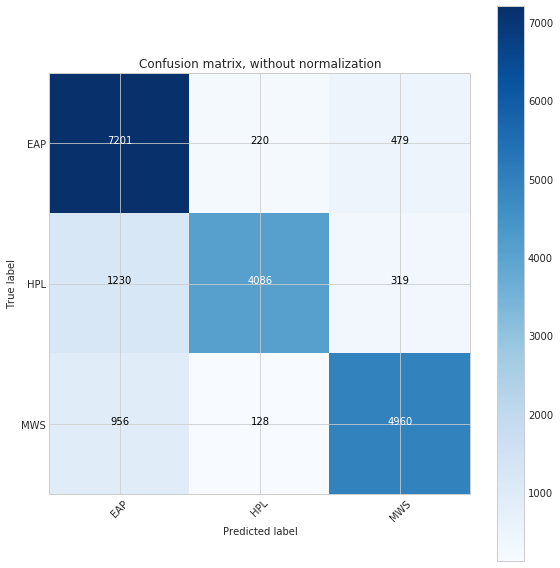

In [39]:
cnf_matrix = confusion_matrix(y_train, np.argmax(mnb_oof_tfc_train, axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Min-max normalization (specified columns)
select_elements = ['word_count', 'char_count', 'word_len_mean', 'unique_word_count', 'stopwords_count', 'punctuations_count', 'word_upper_count', 'word_title_count', 'unique_word_fraction', 'stopwords_fraction', 'punctuations_fraction', 'word_upper_fraction', 'word_title_fraction', 'noun_fraction', 'adj_fraction', 'verbs_fraction']
#train.loc[:, select_elements] =  (train.loc[:, select_elements] - train.loc[:, select_elements].min()) / (train.loc[:, select_elements].max() - train.loc[:, select_elements].min())
#train.head()

## Second-Level Predictions from the First-level Output

In [42]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
#drop_elements = ['id', 'text', 'EAP_markov_3', 'HPL_markov_3', 'MWS_markov_3']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 286) (8392, 286)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,mnb_oof_ctc_mws,rf_oof_ctc_eap,rf_oof_ctc_hpl,rf_oof_ctc_mws,mnb_oof_tfc_eap,mnb_oof_tfc_hpl,mnb_oof_tfc_mws,rf_oof_tfc_eap,rf_oof_tfc_hpl,rf_oof_tfc_mws
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,7.909021e-122,0.421769,0.286445,0.291786,0.999399,0.000045,0.000555,0.413493,0.290686,0.295821
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,1.495738e-28,0.411682,0.283426,0.304893,0.835530,0.116253,0.048217,0.414240,0.279482,0.306279
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,2.904766e-206,0.396871,0.305916,0.297214,0.994561,0.005338,0.000101,0.395220,0.310859,0.293921
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,1.000000e+00,0.345173,0.281935,0.372891,0.000383,0.001570,0.998047,0.344865,0.276892,0.378243
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,9.470971e-53,0.410394,0.290491,0.299115,0.960492,0.026225,0.013283,0.406169,0.289580,0.304251


In [43]:
tmp_x_train = x_train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_train_t = x_train.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

tmp_x_test = x_test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_test_t = x_test.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

# Min-max normalization (column)
#x_train_t = (x_train_t - x_train_t.min()) / (x_train_t.max() - x_train_t.min())
#x_test_t = (x_test_t - x_test_t.min()) / (x_test_t.max() - x_test_t.min())

# Min-max normalization (specified columns)
#select_elements = ['word_count', 'char_count', 'word_len_mean', 'unique_word_count', 'stopwords_count', 'punctuations_count', 'word_upper_count', 'word_title_count']
#train.loc[:, select_elements] =  (train.loc[:, select_elements] - train.loc[:, select_elements].min()) / (train.loc[:, select_elements].max() - train.loc[:, select_elements].min())
#train.head()

# Min-max normalization (row)
tmp_x_train = tmp_x_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
tmp_x_test = tmp_x_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

x_train_t = pd.concat([x_train_t, tmp_x_train], axis=1)
x_test_t = pd.concat([x_test_t, tmp_x_test], axis=1)

x_train_t.head()

,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,rf_oof_ctc_mws,mnb_oof_tfc_eap,mnb_oof_tfc_hpl,mnb_oof_tfc_mws,rf_oof_tfc_eap,rf_oof_tfc_hpl,rf_oof_tfc_mws,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,0.291786,0.999399,0.000045,0.000555,0.413493,0.290686,0.295821,1.000000,0.376305,0.000000
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,0.304893,0.835530,0.116253,0.048217,0.414240,0.279482,0.306279,0.075062,0.000000,1.000000
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.297214,0.994561,0.005338,0.000101,0.395220,0.310859,0.293921,0.000000,1.000000,0.962391
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,0.372891,0.000383,0.001570,0.998047,0.344865,0.276892,0.378243,0.000000,0.519331,1.000000
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,0.299115,0.960492,0.026225,0.013283,0.406169,0.289580,0.304251,0.986159,0.000000,1.000000


In [46]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train_t):
    x_dev, x_val = x_train_t.loc[idx_dev], x_train_t.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test_t)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break # important, only run once

#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.0007	val-mlogloss:1.00069
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.309507	val-mlogloss:0.320854
[80]	train-mlogloss:0.257066	val-mlogloss:0.286126
[120]	train-mlogloss:0.226	val-mlogloss:0.275109
[160]	train-mlogloss:0.202522	val-mlogloss:0.270381
[200]	train-mlogloss:0.183345	val-mlogloss:0.267945
[240]	train-mlogloss:0.166634	val-mlogloss:0.266597
[280]	train-mlogloss:0.151916	val-mlogloss:0.26619
Stopping. Best iteration:
[252]	train-mlogloss:0.161909	val-mlogloss:0.265857

Mean cv score: 0.26585664072990767


In [48]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171129-03.csv", index=False)

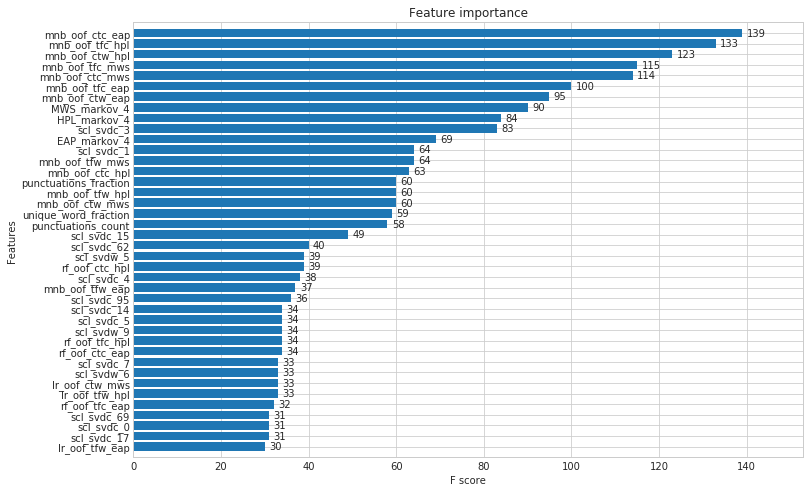

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

# Fuctions

## Multinomial Naive Bayes

In [78]:
def runMNB(x_train, y_train, x_val, x_test):
    model = MultinomialNB()
    model.fit(x_train, y_train)
    pred_y_val = model.predict_proba(x_val)
    pred_y_test = model.predict_proba(x_test)
    return pred_y_val, pred_y_test, model

## XGBoost

In [45]:
xgb_param = {
    'min_child_weight': 1,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}


def runXGB(x_train, y_train, x_val, y_val, x_test):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, y_val)
    dtest = xgb.DMatrix(x_test)
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        xgb_param,
        dtrain,
        2000,
        watchlist,
        early_stopping_rounds=50,
        maximize=False,
        verbose_eval=40)
    pred_y_val = model.predict(dval, ntree_limit=model.best_ntree_limit)
    pred_y_test = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    return pred_y_val, pred_y_test, model

# Feature Engineering

## XGBoost model using Text based features

In [76]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 16) (8392, 16)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,punctuations_fraction,word_upper_fraction,word_title_fraction,noun_fraction,adj_fraction,verbs_fraction
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,0.030303,0.04878,0.073171,0.292683,0.048780,0.146341
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,0.014085,0.00000,0.071429,0.142857,0.071429,0.142857
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,0.025000,0.00000,0.027778,0.277778,0.138889,0.111111
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,0.019417,0.00000,0.117647,0.294118,0.176471,0.147059
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,0.022989,0.00000,0.074074,0.222222,0.037037,0.222222


In [28]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.08762	val-mlogloss:1.08907
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.960029	val-mlogloss:0.984945
[80]	train-mlogloss:0.929692	val-mlogloss:0.967477
[120]	train-mlogloss:0.911581	val-mlogloss:0.959577
[160]	train-mlogloss:0.898984	val-mlogloss:0.956989
[200]	train-mlogloss:0.888438	val-mlogloss:0.955285
[240]	train-mlogloss:0.878812	val-mlogloss:0.954415
[280]	train-mlogloss:0.870162	val-mlogloss:0.954227
Stopping. Best iteration:
[259]	train-mlogloss:0.874821	val-mlogloss:0.953757

[0]	train-mlogloss:1.08797	val-mlogloss:1.08824
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.963335	val-mlogloss:0.974579
[80]	train-mlogloss:0.93324	val-mlogloss:0.953972
[120]	train-mlogloss:0.915465	val-mlogloss:0.94666
[160]	train-m

In [29]:
# add the predictions as new features
#train["xgb_based_eap"] = pred_train[:, 0]
#train["xgb_based_hpl"] = pred_train[:, 1]
#train["xgb_based_mws"] = pred_train[:, 2]
#test["xgb_based_eap"] = pred_full_test[:, 0]
#test["xgb_based_hpl"] = pred_full_test[:, 1]
#test["xgb_based_mws"] = pred_full_test[:, 2]

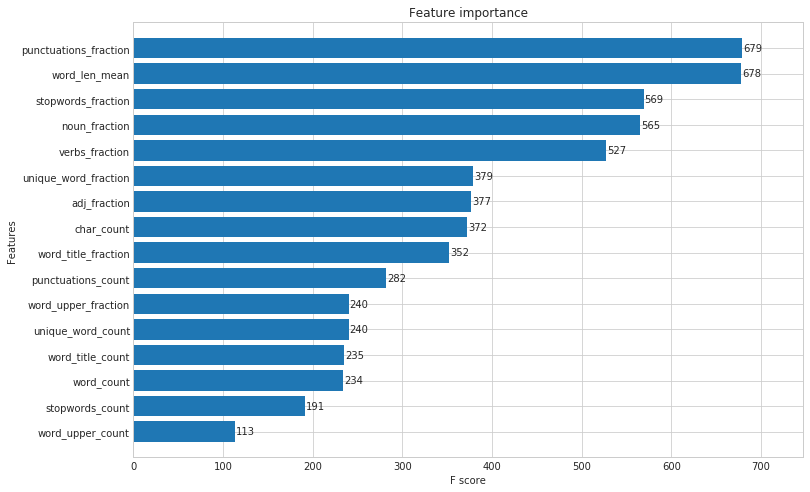

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

## Naive Bayes model using Text based features

In [79]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train):
    x_dev, x_val = x_train.loc[idx_dev], x_train.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, x_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

Mean cv score: 1.039853560846631


In [32]:
# add the predictions as new features
train["nb_based_eap"] = pred_train[:, 0]
train["nb_based_hpl"] = pred_train[:, 1]
train["nb_based_mws"] = pred_train[:, 2]
test["nb_based_eap"] = pred_full_test[:, 0]
test["nb_based_hpl"] = pred_full_test[:, 1]
test["nb_based_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[5935  972  993]
 [3029 2011  595]
 [4294  671 1079]]


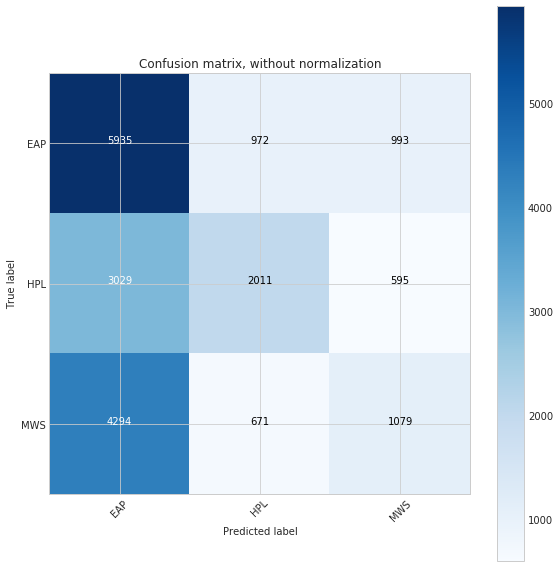

In [81]:
#cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
cnf_matrix = confusion_matrix(y_train, np.argmax(pred_train, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using word Count features

In [36]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tf_train):
    x_dev, x_val = tf_train[idx_dev], tf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.4581034305450692


In [37]:
# add the predictions as new features
train["nb_word_count_eap"] = pred_train[:, 0]
train["nb_word_count_hpl"] = pred_train[:, 1]
train["nb_word_count_mws"] = pred_train[:, 2]
test["nb_word_count_eap"] = pred_full_test[:, 0]
test["nb_word_count_hpl"] = pred_full_test[:, 1]
test["nb_word_count_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1308  110  177]
 [ 111  899   88]
 [ 121   50 1051]]


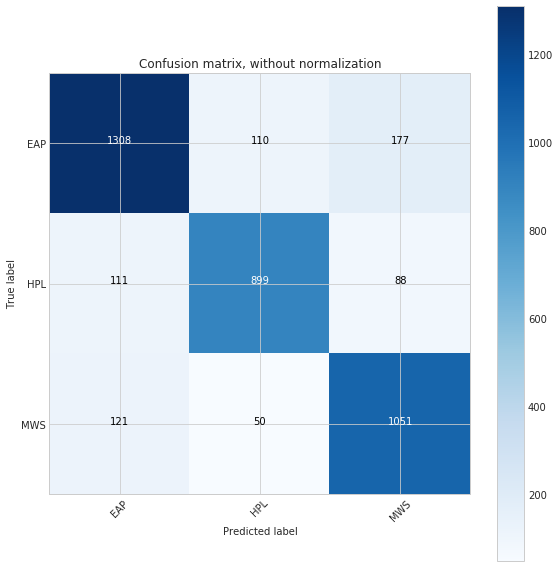

In [38]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using word TFIDF features

In [39]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidf_train):
    x_dev, x_val = tfidf_train[idx_dev], tfidf_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidf_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8335510961069861


In [40]:
# add the predictions as new features
train["nb_word_tfidf_eap"] = pred_train[:, 0]
train["nb_word_tfidf_hpl"] = pred_train[:, 1]
train["nb_word_tfidf_mws"] = pred_train[:, 2]
test["nb_word_tfidf_eap"] = pred_full_test[:, 0]
test["nb_word_tfidf_hpl"] = pred_full_test[:, 1]
test["nb_word_tfidf_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1532   16   47]
 [ 522  530   46]
 [ 453   11  758]]


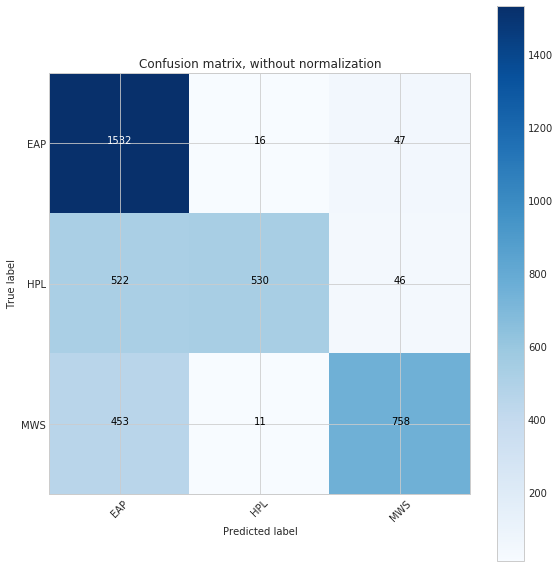

In [41]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using char Count features

In [45]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfc_train):
    x_dev, x_val = tfc_train[idx_dev], tfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 3.725182058538286


In [46]:
# add the predictions as new features
train["nb_char_count_eap"] = pred_train[:, 0]
train["nb_char_count_hpl"] = pred_train[:, 1]
train["nb_char_count_mws"] = pred_train[:, 2]
test["nb_char_count_eap"] = pred_full_test[:, 0]
test["nb_char_count_hpl"] = pred_full_test[:, 1]
test["nb_char_count_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1348   97  150]
 [ 141  887   70]
 [ 114   57 1051]]


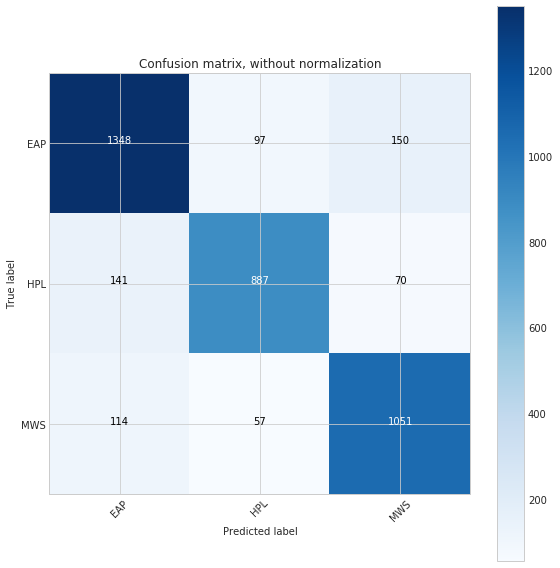

In [47]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## Naive Bayes model using char TFIDF features

In [48]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(tfidfc_train):
    x_dev, x_val = tfidfc_train[idx_dev], tfidfc_train[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runMNB(x_dev, y_dev, x_val, tfidfc_test)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score : {}".format(np.mean(cv_scores)))

Mean cv score : 0.8924656818342923


In [49]:
# add the predictions as new features
train["nb_char_tfidf_eap"] = pred_train[:, 0]
train["nb_char_tfidf_hpl"] = pred_train[:, 1]
train["nb_char_tfidf_mws"] = pred_train[:, 2]
test["nb_char_tfidf_eap"] = pred_full_test[:, 0]
test["nb_char_tfidf_hpl"] = pred_full_test[:, 1]
test["nb_char_tfidf_mws"] = pred_full_test[:, 2]

Confusion matrix, without normalization
[[1578    2   15]
 [ 850  233   15]
 [ 798    4  420]]


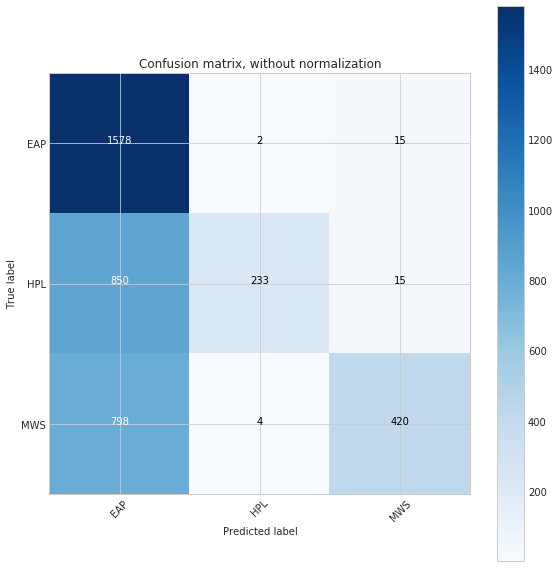

In [50]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## lda TODO

In [60]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = ("\nTopic #{}: ").format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [61]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda.fit(tf_train)


n_top_words = 20
print("Topics in LDA model: ")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]

first_topic.shape


first_topic_words = [
    tfidf_feature_names[i] for i in first_topic.argsort()[:-50 - 1:-1]
]
second_topic_words = [
    tfidf_feature_names[i] for i in second_topic.argsort()[:-50 - 1:-1]
]
third_topic_words = [
    tfidf_feature_names[i] for i in third_topic.argsort()[:-50 - 1:-1]
]

Topics in LDA model: 

Topic #0: long think appeared subject time die peculiar escape regard public miserable duty law health ye mentioned vague evidently hope moment

Topic #1: eye hand hour moment came left time fear far water face moon general saw turned lay longer large foot away

Topic #2: love beauty secret sun thought shore silent wind act mountain music long cloud covered sea rich reality heart sky native

Topic #3: child sleep street perdita saw home imagination cast lord tomb window threw enemy house early vain ancient melancholy progress raymond

Topic #4: shall eye began raymond adrian expression head hand cottage later terrible lovely yes feel deep changed answer limb grave frame

Topic #5: man day night life like old word great did year dream father said body little time thing come light friend

Topic #6: thing said good let sound certain heard felt know say thought character did world matter present old kind nature earth

Topic #7: wide opinion say burst fly captain view

## --- Sentiment Analysis based features ---

# Ensembling & Stacking models

In [62]:
# Prepare the data for modeling
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train['author'].map(author_mapping_dict)
id_train = train['id'].values
id_test = test['id'].values

drop_elements = ['id', 'text']
#drop_elements = ['id', 'text', 'EAP_markov_3', 'HPL_markov_3', 'MWS_markov_3']
x_train = train.drop(drop_elements + ['author'], axis=1)
x_test = test.drop(drop_elements, axis=1)

print(x_train.shape, x_test.shape)
x_train.head()

(19579, 157) (8392, 157)


,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,svd_char_53,svd_char_54,svd_char_55,svd_char_56,svd_char_57,svd_char_58,svd_char_59,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,-0.011059,0.005948,0.008063,0.014421,0.001487,0.043720,-0.028494,-260.951265,-264.558275,-266.734553
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,-0.040323,-0.015659,0.029809,0.028681,0.018564,0.009284,0.031175,-84.555513,-84.948988,-79.706974
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.039628,-0.010639,0.020787,-0.017877,-0.011637,-0.031067,-0.006147,-243.907011,-226.005790,-226.679045
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,-0.016082,0.012017,-0.019450,0.009076,0.020781,-0.023522,-0.003019,-286.945996,-279.407828,-272.430841
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,-0.013709,-0.016478,-0.012827,0.020846,0.000646,-0.008593,-0.005174,-220.812198,-231.215919,-220.666175


In [63]:
tmp_x_train = x_train[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_train_t = x_train.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

tmp_x_test = x_test[['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)]]
x_test_t = x_test.drop(['EAP_markov_' + str(order), 'HPL_markov_' + str(order), 'MWS_markov_' + str(order)], axis=1)

# Min-max normalization (column)
#x_train_t = (x_train_t - x_train_t.min()) / (x_train_t.max() - x_train_t.min())
#x_test_t = (x_test_t - x_test_t.min()) / (x_test_t.max() - x_test_t.min())

# Min-max normalization (specified columns)
#select_elements = ['word_count', 'char_count', 'word_len_mean', 'unique_word_count', 'stopwords_count', 'punctuations_count', 'word_upper_count', 'word_title_count']
#train.loc[:, select_elements] =  (train.loc[:, select_elements] - train.loc[:, select_elements].min()) / (train.loc[:, select_elements].max() - train.loc[:, select_elements].min())
#train.head()

# Min-max normalization (row)
tmp_x_train = tmp_x_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
tmp_x_test = tmp_x_test.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

x_train_t = pd.concat([x_train_t, tmp_x_train], axis=1)
x_test_t = pd.concat([x_test_t, tmp_x_test], axis=1)

x_train_t.head()

,word_count,char_count,word_len_mean,unique_word_count,stopwords_count,punctuations_count,word_upper_count,word_title_count,unique_word_fraction,stopwords_fraction,...,svd_char_53,svd_char_54,svd_char_55,svd_char_56,svd_char_57,svd_char_58,svd_char_59,EAP_markov_4,HPL_markov_4,MWS_markov_4
0,41,231,4.487805,35,20,7,2,3,0.853659,0.487805,...,-0.011059,0.005948,0.008063,0.014421,0.001487,0.043720,-0.028494,1.000000,0.376305,0.000000
1,14,71,4.071429,14,8,1,0,1,1.000000,0.571429,...,-0.040323,-0.015659,0.029809,0.028681,0.018564,0.009284,0.031175,0.075062,0.000000,1.000000
2,36,200,4.444444,32,17,5,0,1,0.888889,0.472222,...,0.039628,-0.010639,0.020787,-0.017877,-0.011637,-0.031067,-0.006147,0.000000,1.000000,0.962391
3,34,206,4.970588,31,13,4,0,4,0.911765,0.382353,...,-0.016082,0.012017,-0.019450,0.009076,0.020781,-0.023522,-0.003019,0.000000,0.519331,1.000000
4,27,174,5.333333,25,11,4,0,2,0.925926,0.407407,...,-0.013709,-0.016478,-0.012827,0.020846,0.000646,-0.008593,-0.005174,0.986159,0.000000,1.000000


## Kfold method

In [64]:
n_splits = 5
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])

for idx_dev, idx_val in kf.split(x_train_t):
    x_dev, x_val = x_train_t.loc[idx_dev], x_train_t.loc[idx_val]
    y_dev, y_val = y_train[idx_dev], y_train[idx_val]
    pred_y_val, pred_y_test, model = runXGB(x_dev, y_dev, x_val, y_val, x_test_t)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[idx_val, :] = pred_y_val
    cv_scores.append(metrics.log_loss(y_val, pred_y_val))
    break # important, only run once

#pred_full_test = pred_full_test / float(n_splits)
print("Mean cv score: {}".format(np.mean(cv_scores)))

[0]	train-mlogloss:1.00057	val-mlogloss:1.00074
Multiple eval metrics have been passed: 'val-mlogloss' will be used for early stopping.

Will train until val-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.322333	val-mlogloss:0.337818
[80]	train-mlogloss:0.273864	val-mlogloss:0.306222
[120]	train-mlogloss:0.244693	val-mlogloss:0.293842
[160]	train-mlogloss:0.223139	val-mlogloss:0.287865
[200]	train-mlogloss:0.206077	val-mlogloss:0.284418
[240]	train-mlogloss:0.190312	val-mlogloss:0.281825
[280]	train-mlogloss:0.176312	val-mlogloss:0.280139
[320]	train-mlogloss:0.164154	val-mlogloss:0.279032
[360]	train-mlogloss:0.152511	val-mlogloss:0.278469
[400]	train-mlogloss:0.141835	val-mlogloss:0.278662
Stopping. Best iteration:
[375]	train-mlogloss:0.148132	val-mlogloss:0.278189

Mean cv score: 0.27818935575459686


In [66]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171129-02.csv", index=False)

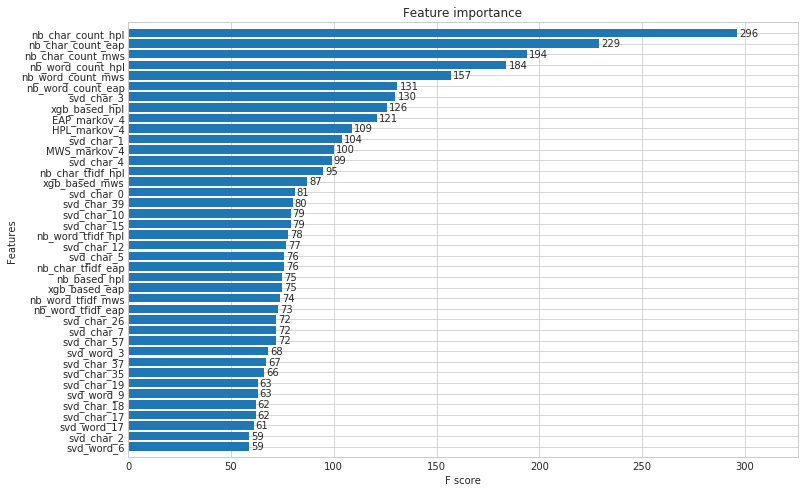

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:40]),
    ax=ax,
    height=0.8)
plt.show()

Confusion matrix, without normalization
[[1389   57   90]
 [  86 1038   44]
 [ 118   47 1047]]


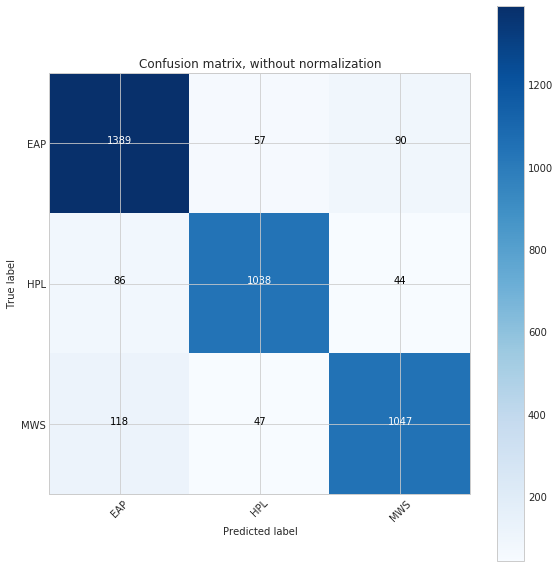

In [68]:
cnf_matrix = confusion_matrix(y_val, np.argmax(pred_y_val, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['EAP', 'HPL', 'MWS'],
    title='Confusion matrix, without normalization')
plt.show()

## train_test_split method

In [69]:
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(
    x_train_t, y_train, test_size=0.2, random_state=2017)
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dval = xgb.DMatrix(xval, label=yval)
dtest = xgb.DMatrix(x_test_t)
watchlist = [(dtrain, 'train'), (dval, 'valid')]

model_2 = xgb.train(
    xgb_param,
    dtrain,
    2000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)

[0]	train-mlogloss:1.00057	valid-mlogloss:1.00055
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.323143	valid-mlogloss:0.338021
[80]	train-mlogloss:0.272177	valid-mlogloss:0.304934
[120]	train-mlogloss:0.244781	valid-mlogloss:0.29281
[160]	train-mlogloss:0.223242	valid-mlogloss:0.286911
[200]	train-mlogloss:0.205899	valid-mlogloss:0.28303
[240]	train-mlogloss:0.190363	valid-mlogloss:0.280969
[280]	train-mlogloss:0.176594	valid-mlogloss:0.279128
[320]	train-mlogloss:0.16433	valid-mlogloss:0.278363
[360]	train-mlogloss:0.152922	valid-mlogloss:0.278301
[400]	train-mlogloss:0.1428	valid-mlogloss:0.277563
[440]	train-mlogloss:0.133301	valid-mlogloss:0.278427
Stopping. Best iteration:
[407]	train-mlogloss:0.141157	valid-mlogloss:0.277509



In [217]:
pred_y_test = model_2.predict(dtest, ntree_limit=model_2.best_ntree_limit)

out_df = pd.DataFrame(pred_y_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', id_test)
out_df.to_csv("../result/submission-20171128-04.csv", index=False)

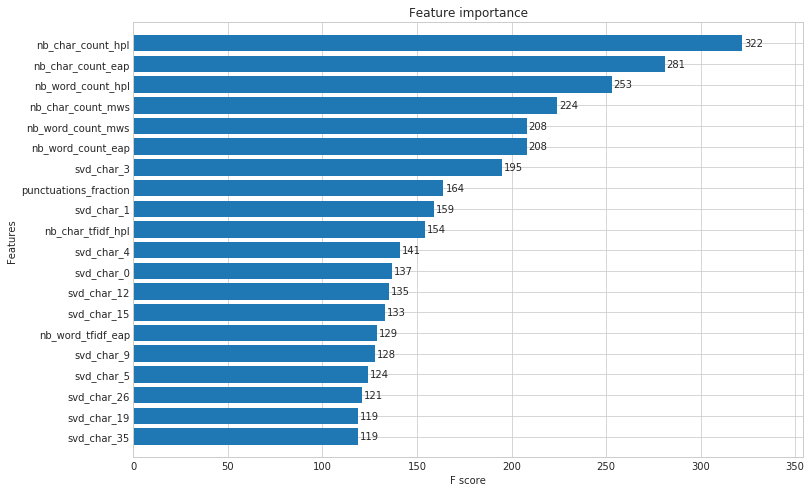

In [216]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    dict(
        sorted(model_2.get_fscore().items(), reverse=True, key=lambda x: x[1])
        [:20]),
    ax=ax,
    height=0.8)
plt.show()